# **HAVOK study** | forcing characterization

**DOUBLE THRESHOLD**

*Ref*: [github@baronefr/havok-analysis](github.com/baronefr/havok-analysis)

In this notebook we show a sample of the havok analysis using our **rhavok library**.

In [1]:
from rhavok.havok import havok

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

# color map used in this notebook
this_cm = plt.get_cmap('gist_rainbow')

In [2]:
# behavioural
do_gridsearch = False

#### Data import

We import the test dataset from a previously done HAVOK analysis.

In [3]:
data_path = './data/data_havok/'
vv = np.loadtxt(data_path + 'test_v.csv')
tt = np.loadtxt(data_path + 'test_t.csv')
xx = np.loadtxt(data_path + 'test_x.csv')

In [4]:
print(vv.shape[1], 'signatures available')

20 signatures available


### Visualize the embedded coordinates

In [5]:
# plot spectrum of embedded coordinates
def plot_embedded_spectrum(x, t, v,             # data
                  limit, selection = None,      # what to plot
                  vf = lambda x: x,             # transformation function for v
                  figsize = (10,9), alpha = 1): # aesthetics
    
    limit = np.arange(limit[0], limit[1])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[1,2]}, figsize=figsize, sharex=True)
    ax1.plot(t[limit], x[limit], c='k')
    ax1.set_ylabel('x(t)')
    
    if selection is None:
        selection = np.arange(2,v.shape[1]+1)
    elif isinstance(selection, int):
        selection = np.arange(2,selection+1)
    elif isinstance(selection, tuple):
        selection = np.arange(selection[0],selection[1]+1)
    elif isinstance(selection, list):
        pass
    selection = list(selection)
    
    ax2.set_prop_cycle( cycler( color=[this_cm(1.*i/len(selection)) for i in range(len(selection))] ))
    
    for ts in selection:
        ax2.plot(t[limit], vf(v[limit,ts-1]), label=str(ts), alpha=alpha)
    
    ax2.set_ylabel(r"$v_i(t)$")
    ax2.set_ylim([-.021,.021])
    ax2.legend()

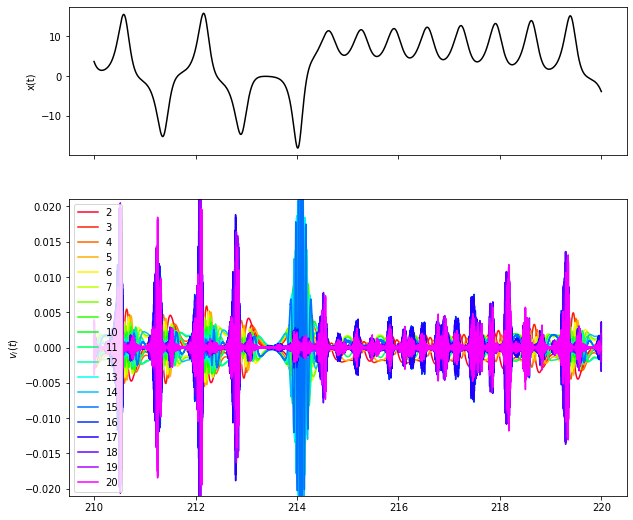

In [6]:
plot_embedded_spectrum(xx, tt, vv, [10000,20000])

## part 1 | double hard thresholding

In [7]:
#  Activity criteria: create a cluster when forcing
# signals are greater than a threashold
def activity_by_double_threshold(forcing, thres = [0.002, 0.002]):
    
    ath1 = abs(forcing[0]) > thres[0]
    ath2 = abs(forcing[1]) > thres[1]
    above_thres = np.array( [any(t) for t in zip(ath1, ath2)] , dtype = bool)
    thres_expand = 500
    switch = False
    for i in range(0,len(above_thres)):
        if above_thres[i]:
            if not switch:
                above_thres[i:i+thres_expand] = True
                switch = True
        else:
            switch = False
    
    return above_thres

In [8]:
# roc curve for hard thresholding
def yaroc(obj, data, forcing, thres = [0.002, 0.002]):
    
    active_mask = activity_by_double_threshold(forcing, thres = thres)
    
    nswitch = 0
    ntrigger = 0
    tp = 0
    
    ntimeseries = len(forcing[0])
    prev_value = data[0]
    prev_trigger = False
    # let's walk though the timeseries
    for i in range(ntimeseries):
        if prev_value*data[i] <= 0:
            # there is a sign switch
            nswitch += 1
            if np.any(active_mask[(i-200):i]): tp += 1
            prev_value = data[i]
            
        if (active_mask[i] == True) and (prev_trigger == False): ntrigger += 1
        prev_trigger = active_mask[i]
    return tp, nswitch, ntrigger

In [9]:
# small demo on 15 th forcing term
tp, nsw, ntr = yaroc(None, xx, [vv[:,14], vv[:,14]])
print("tpr = {}, fpr = {}".format( round(tp/nsw,3), round(1 - (tp/ntr),3)))
def_thres = (tp/nsw, 1 - (tp/ntr))

tpr = 0.961, fpr = 0.158


In [10]:
def ROC(forcing, thr_test):
    tp, nsw, ntr = yaroc(None, xx[-len(forcing):], forcing, thr_test)
    tpr = tp/nsw
    if ntr == 0: fpr = 0
    else: fpr = 1 - (tp/ntr)
    return tpr, fpr

<br>

#### create ROC for a couple of ranks

In [11]:
selected_ranks = [vv[:,14], vv[:,19]]

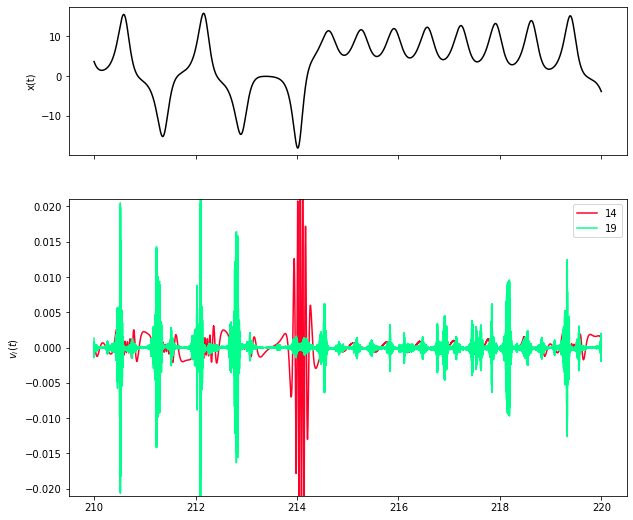

In [12]:
plot_embedded_spectrum(xx, tt, vv, [10000,20000], selection = [14,19])

In [13]:
if do_gridsearch:
    thr_x = np.arange(0.001, 0.0221, 0.001)
    nx = len(thr_x)
    thr_y = np.arange(0.001, 0.0221, 0.001)
    ny = len(thr_y)
    
    print('> gridsearch', nx,'x', ny)
    
    fpr_matrix = np.full( (nx,ny), np.nan)
    tpr_matrix = np.full( (nx,ny), np.nan)
    
    for i in range(nx):
        for j in range(ny):
            tp, nsw, ntr = yaroc(None, xx, [vv[:,14], vv[:,19]],
                                 thres = [ thr_x[i], thr_y[j] ] )
            tpr = tp/nsw
            if ntr == 0: fpr = 0
            else: fpr = 1 - (tp/ntr)
            fpr_matrix[i,j] = fpr
            tpr_matrix[i,j] = tpr
    
else:
    tpr_matrix = np.loadtxt('gridsearch_tpr.csv')
    fpr_matrix = np.loadtxt('gridsearch_fpr.csv')
    thr_tmp = np.loadtxt('gridsearch_thr.csv')
    
    thr_x = thr_tmp[0];    nx = len(thr_x);
    thr_y = thr_tmp[1];    ny = len(thr_y);
    nx = tpr_matrix.shape[0];  ny = tpr_matrix.shape[0];
    print('> loaded gridsearch', nx,'x', ny)

> loaded gridsearch 22 x 22


In [14]:
# dump gridsearch
if False:
    np.savetxt('gridsearch_tpr.csv', tpr_matrix)
    np.savetxt('gridsearch_fpr.csv', fpr_matrix)
    np.savetxt('gridsearch_thr.csv', [thr_x.T, thr_y.T])

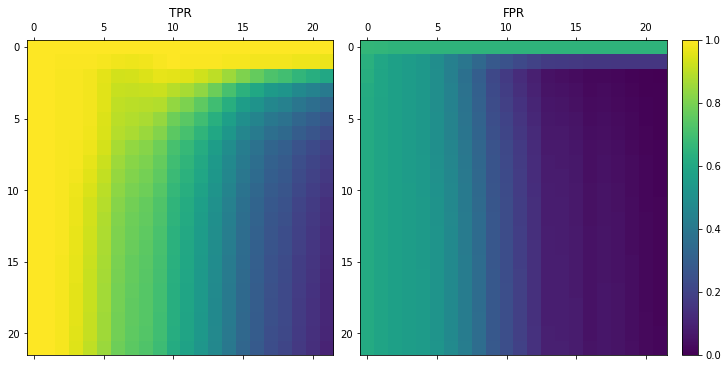

In [15]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,5))
ax[0].matshow(tpr_matrix, vmin=0, vmax=1, aspect='auto')
ax[0].set_title('TPR')

pc = ax[1].matshow(fpr_matrix, vmin=0, vmax=1, aspect='auto')
ax[1].set_title('FPR')

fig.colorbar(pc, ax=ax[1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


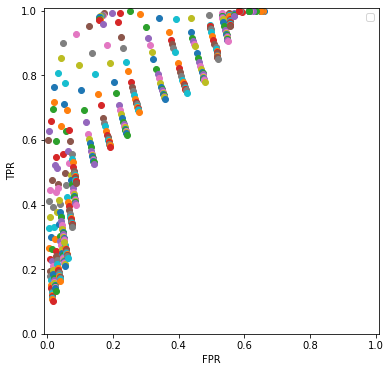

In [16]:
plt.figure(figsize=(6,6))

for i in range(nx):
    for j in range(ny):
        plt.scatter(fpr_matrix[i,j], tpr_matrix[i,j])
        
plt.xlim([-.01,1.01])
plt.ylim([0,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

***

Code by *Francesco Barone*, last review: 1 jun 2022. <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele, Valentini Lorenzo.

University of Padua, **Laboratory of Computational Physics**, module B.